## Artificial Intelligence (BSc) SA 2025-2026

- Prof. Luca Gambardella
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>

---

## 2th Lab

What we are going to do today:
- Simluated Annealing algorithm from scratch and using Mealpy

### Simulated Annealing from Scratch


In [10]:
import numpy as np

from utils import compute_length, ProblemInstance, SolverTSP

def sa_swap2opt(tsp_sequence, i, j):
    new_tsp_sequence = np.copy(tsp_sequence)
    new_tsp_sequence[i:j + 1] = np.flip(tsp_sequence[i:j + 1], axis=0)  # flip or swap ?
    return new_tsp_sequence

def gain(i, j, tsp_sequence, matrix_dist):
    old_link_len = (matrix_dist[tsp_sequence[i], tsp_sequence[i - 1]] + matrix_dist[
        tsp_sequence[j], tsp_sequence[j + 1]])
    changed_links_len = (matrix_dist[tsp_sequence[j], tsp_sequence[i - 1]] + matrix_dist[
        tsp_sequence[i], tsp_sequence[j + 1]])
    return - old_link_len + changed_links_len

# genrate a random solution that is neighbor to the existng solution
def random_sol_from_neigh(solution, instance):
    # generate 2 random i and j
    i, j = np.random.choice(np.arange(1, len(solution) - 1), 2, replace=False)
    # sort i and j
    i, j = np.sort([i, j])
    solution = np.roll(solution, np.random.randint(len(solution)))
    # do an 2opt swap based on the 2 random i an j generated, and compute the gain of this 2opt
    return sa_swap2opt(solution, i, j), gain(i, j, solution, instance.dist_matrix)


def sa(solution, instance, constant_temperature=0.95, iterations_for_each_temp=100):
    # initial setup
    # initialize the temperature T = tmax
    temperature = instance.best_sol / np.sqrt(instance.nPoints)

    # initializing initial solution and len (x)
    current_sol = np.array(solution)
    # initial energey of x, E(x), energy is the tour lenght
    current_len = compute_length(solution, instance.dist_matrix)

    # variables to save the best sol
    best_sol = np.array(solution)
    best_len = current_len
    # main loop
    while temperature > 0.001: # lowest accepted temperature, T > Tmin and E > Eth
        # TODO
        # equilibrium for the current temperature, or specify max iteration for each temperature
        for it in range(iterations_for_each_temp):
            # generate new candidate solution from neighbors
            next_sol, delta_E = random_sol_from_neigh(current_sol, instance)
            # if neighbor solution is an improvment: accept it and save it in current and best solution variables
            if delta_E < 0:
                current_sol = next_sol
                current_len += delta_E
                if current_len < best_len:
                    best_sol = current_sol
                    best_len = current_len
            else: # neighbor solution is not an improvment: compute exp(-deltaE/T) and generate a random number r in range [0, 1] and decide if accept it or not
                r = np.random.uniform(0, 1)
                if r < np.exp(- delta_E / temperature):
                    current_sol = next_sol
                    current_len += delta_E

        # decrease temperature
        temperature *= constant_temperature
    # END TODO
    # return best tour solution
    return best_sol.tolist()

###  solving with random  ####
###  solved  ####


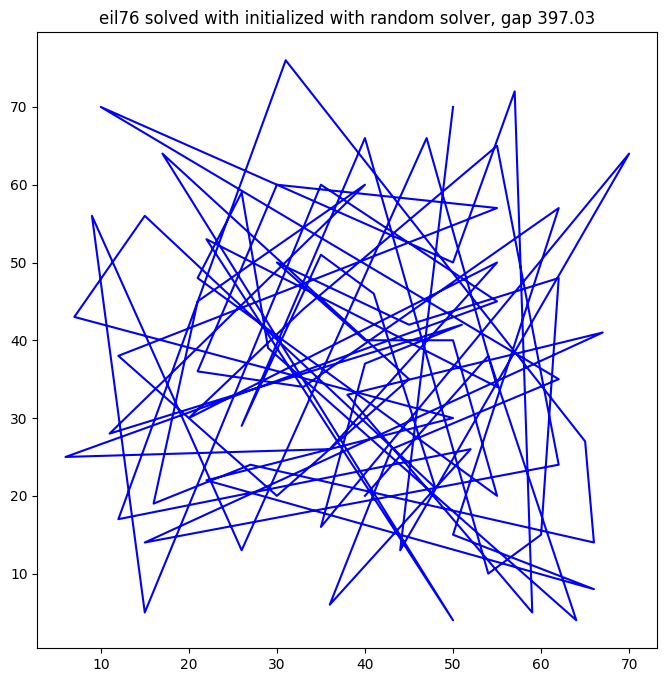

best solution with len 2674.0 
with a total time of 0.0005 seconds
solution found has a 397.03 % gap
0.6424596309661865


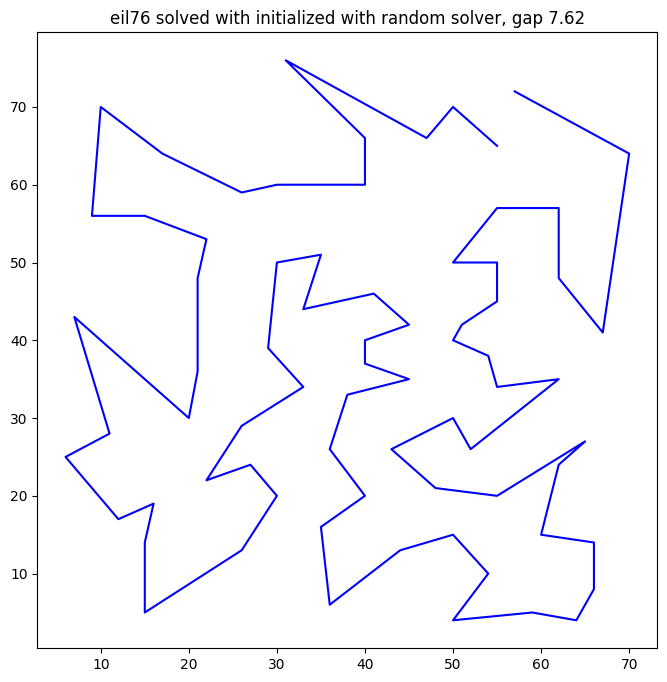

SA 7.62 % gap


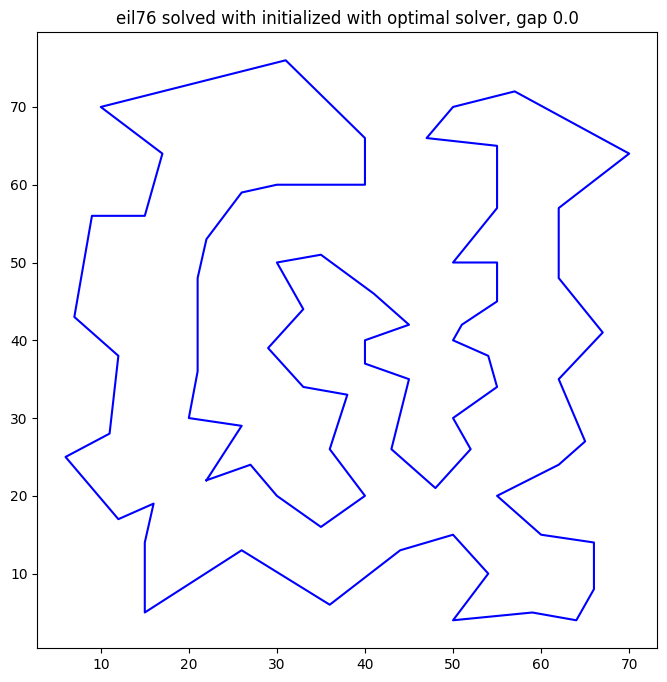

In [11]:
from time import time as t
from constructive import (
    random_method,
)

available_solvers = {
    "random": random_method,
}

example_problem = "./problems/eil76.tsp"
p_inst = ProblemInstance(example_problem)

solver = SolverTSP("random", p_inst, available_solvers)
start = t()
solver.compute_solution(return_value=False, verbose=True)
end = t()

initial_solution = solver.solution

solver.plot_solution()
print(f"best solution with len {solver.found_length} \nwith a total time of {np.round(end - start, 5)} seconds")
print(f"solution found has a {solver.gap} % gap")

start = t()
solution = sa(solver.solution, p_inst)
end = t()
print(end -  start)
solver.method = "SA"

#assert solver.pass_and_check_if_solution_is_valid(solution), "Solution non valid"
solver.solved = True
solver.solution = solution
solver.plot_solution()
solver._gap()
print(f"SA {solver.gap} % gap")


solver = SolverTSP("optimal", p_inst,available_solvers)
solver.solved = True
# the solution is the optimal tour
solver.solution = np.concatenate([p_inst.optimal_tour, [p_inst.optimal_tour[0]]])
solver.plot_solution()

### Simulated Annealing with Mealpy

In [12]:
# generate a random solution that is neighbor to the existng solution
def random_sol_from_neigh_mealpy(solution):
    # generate 2 random i and j
    i, j = np.random.choice(np.arange(1, len(solution) - 1), 2, replace=False)
    # sort i and j
    i, j = np.sort([i, j])
    solution = np.roll(solution, np.random.randint(len(solution)))
    # do an 2opt swap based on the 2 random i an j generated, and compute the gain of this 2opt
    return sa_swap2opt(solution, i, j)

def compute_gap(optimal, best_found):
    return np.round(((best_found - optimal) / optimal) * 100, 2)

In [13]:
import mealpy
print(mealpy.__version__)

3.0.1


In [14]:
from mealpy import PermutationVar, Problem, SA
from mealpy.utils.agent import Agent

# Define the positions of the cities
# city_positions = np.array([[60, 200], [180, 200], [80, 180], [140, 180], [20, 160],
#                            [100, 160], [200, 160], [140, 140], [40, 120], [100, 120],
#                            [180, 100], [60, 80], [120, 80], [180, 60], [20, 40],
#                            [100, 40], [200, 40], [20, 20], [60, 20], [160, 20]])


city_positions = p_inst.points[:, 1:3]

num_cities = len(city_positions)
data = {
    "city_positions": city_positions,
    "num_cities": num_cities,
}

class TspProblem(Problem):
    def __init__(self, bounds=None, minmax="min", data=None, **kwargs):
        self.data = data
        super().__init__(bounds, minmax, **kwargs)
        
                
    @staticmethod
    def calculate_distance(city_a, city_b):
        rounding = 0
        x_i, y_i = city_a[0], city_a[1]
        x_j, y_j = city_b[0], city_b[1]
        # use the numpy sqrt method
        distance = np.sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2)
        return round(distance, rounding)

    @staticmethod
    def calculate_total_distance(route, city_positions):
        # Calculate total distance of a route
        total_distance = 0
        num_cities = len(route)
        for idx in range(num_cities):
            current_city = int(route[idx])
            next_city = int(route[(idx + 1) % num_cities])  # Wrap around to the first city
            total_distance += TspProblem.calculate_distance(city_positions[current_city], city_positions[next_city])
        return total_distance

    def obj_func(self, x):
        route = x
        fitness = self.calculate_total_distance(route, self.data["city_positions"])
        return fitness


# Custom Simulated Annealing class
class CustomTSPSA(SA.OriginalSA):
    
    def __init__(self, epoch: int = 10000, pop_size: int = 2, temp_init: float = 100, step_size: float = 0.1,
                 **kwargs: object):
        super().__init__(epoch, pop_size, temp_init, step_size)

    
    def initialize_variables(self):
        print('Initializing TSP Agents...')
        self.g_best = Agent()
        self.g_best.solution = np.array(initial_solution)
        self.g_best.target = self.problem.get_target(self.g_best.solution)

        
    def generate_agent(self, solution: np.ndarray = None) -> Agent:
        """
        Generate new agent with full information

        Args:
            solution (np.ndarray): The solution
        """
        if solution is None:
            print('Initializing TSP solution...')
            solution = initial_solution
            agent = Agent(solution=solution, target=self.problem.get_target(solution))
            return agent
                
        agent = Agent(solution=solution, target=self.problem.get_target(solution))
           
        agent.solution = random_sol_from_neigh_mealpy(solution)
        agent.target = problem.get_target(agent.solution)
        return agent
    
    
    def evolve(self, epoch):
        """
        The main operations (equations) of algorithm. Inherit from Optimizer class

        Args:
            epoch (int): The current iteration
        """
        # Perturb the current solution
        agent = self.generate_agent(self.agent_current.solution)
        # Accept or reject the new solution
        if self.compare_target(agent.target, self.agent_current.target, self.problem.minmax):
            self.agent_current = agent
        else:
            # Calculate the energy difference
            delta_energy = np.abs(self.agent_current.target.fitness - agent.target.fitness)
            # calculate probability acceptance criterion
            p_accept = np.exp(-delta_energy/ (self.temp_init / float(epoch + 1)))
            if self.generator.random() < p_accept:
                self.agent_current = agent
                
        self.pop = [self.g_best.copy(), self.agent_current.copy()]

In [15]:
bounds = PermutationVar(valid_set=list(range(0, num_cities)), name="per_var")
problem = TspProblem(bounds=bounds, minmax="min", data=data)

model = CustomTSPSA(epoch=1500, pop_size=2, temp_init = 100, step_size = 0.01)

g_best = model.solve(problem)

print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")

print(f"Best agent: {model.g_best}")                    # Encoded solution
print(f"Best solution: {model.g_best.solution}")        # Encoded solution
print(f"Best fitness: {model.g_best.target.fitness}")
print(f"Best real scheduling: {model.problem.decode_solution(model.g_best.solution)}")      # Decoded (Real) solution

2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: Solving single objective optimization problem.
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 1, Current best: 2661.0, Global best: 2661.0, Runtime: 0.00113 seconds
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 2, Current best: 2654.0, Global best: 2654.0, Runtime: 0.00136 seconds
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 3, Current best: 2614.0, Global best: 2614.0, Runtime: 0.00133 seconds
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 4, Current best: 2594.0, Global best: 2594.0, Runtime: 0.00144 seconds
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 5, Current best: 2561.0, Global best: 2561.0, Runtime: 0.00044 seconds
2025/10/07 01:34:52 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 6, Current best: 2561.0, Global best: 2561.0, Runtime: 0.00045 seconds
2025/10/07 01:34:52 PM, INFO, _

Initializing TSP Agents...
Initializing TSP solution...
Initializing TSP solution...


2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 113, Current best: 1834.0, Global best: 1834.0, Runtime: 0.00151 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 114, Current best: 1834.0, Global best: 1834.0, Runtime: 0.00137 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 115, Current best: 1834.0, Global best: 1834.0, Runtime: 0.00094 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 116, Current best: 1825.0, Global best: 1825.0, Runtime: 0.00051 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 117, Current best: 1825.0, Global best: 1825.0, Runtime: 0.00093 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 118, Current best: 1813.0, Global best: 1813.0, Runtime: 0.00066 seconds
2025/10/07 01:34:53 PM, INFO, __main__.CustomTSPSA: >>>Problem: P, Epoch: 119, Current best: 1813.0, Global best: 1813

Solution: [50 16 75 25 39 43 17 54 24 38 71 37 30  9 57 52  6 13 65 64 10 58 53 18
 34  7 45 67 66 74 33 51 12 14 26 56  4 28 44  3  5 15 72  1 29 20 73 27
 46 47 70 59 36 19 69 35 68 60 21 61 32  0 42 63 41 40 55 22 62 11  8 49
  2 48 23 31], Fitness: 795.0
Solution: [50 16 75 25 39 43 17 54 24 38 71 37 30  9 57 52  6 13 65 64 10 58 53 18
 34  7 45 67 66 74 33 51 12 14 26 56  4 28 44  3  5 15 72  1 29 20 73 27
 46 47 70 59 36 19 69 35 68 60 21 61 32  0 42 63 41 40 55 22 62 11  8 49
  2 48 23 31], Fitness: 795.0
Best agent: id: 7510, target: Objectives: [795.], Fitness: 795.0, solution: [50 16 75 25 39 43 17 54 24 38 71 37 30  9 57 52  6 13 65 64 10 58 53 18
 34  7 45 67 66 74 33 51 12 14 26 56  4 28 44  3  5 15 72  1 29 20 73 27
 46 47 70 59 36 19 69 35 68 60 21 61 32  0 42 63 41 40 55 22 62 11  8 49
  2 48 23 31]
Best solution: [50 16 75 25 39 43 17 54 24 38 71 37 30  9 57 52  6 13 65 64 10 58 53 18
 34  7 45 67 66 74 33 51 12 14 26 56  4 28 44  3  5 15 72  1 29 20 73 27
 46 47 70 59

In [16]:
gap = compute_gap(p_inst.best_sol, model.g_best.target.fitness)
gap

47.77

In [17]:
model.g_best.target.fitness, p_inst.best_sol

(795.0, 538.0)